In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import glob as gb
from functools import reduce
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import numpy as np
plt.style.use('classic')

In [2]:
## Canvas parameters

# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 9 and height to 6
fig_size[0] = 8
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

In [18]:
## Getting data from files of OS and ESA

OS1 = [file for file in gb.glob("ALL0001/*CH2.CSV")] # Cavity
OS2 = [file for file in gb.glob("ALL0002/*CH1.CSV")] # PZT
OS3 = [file for file in gb.glob("ALL0002/*CH2.CSV")] # Peaks
OS4 = [file for file in gb.glob("ALL0003/*CH2.CSV")] # Locking 1
OS5 = [file for file in gb.glob("ALL0004/*CH2.CSV")] # Locking 2
OS6 = [file for file in gb.glob("ALL0005/*CH2.CSV")] # no-signal

filesOS = [x for y in [OS1, OS2, OS3, OS4, OS5, OS6] for x in y] # Flat list

col_namesOS = [ ['t','DC1'], ['t','DC2'], ['t','DC3'],
              ['t','DC4'], ['t','DC5'], ['t','DC6']]

#OS Tektronix
data_OSs = [pd.read_csv(trace, sep=',', usecols=[3,4], 
                        header=None, names=cols)
               for trace,cols in zip(filesOS, col_namesOS)]

data_cav = data_OSs[0] # Cavity peak
data_cav2 = reduce(lambda x,y: pd.merge(x,y, on='t'), 
                   (data_OSs[1], data_OSs[2])) # PZT & Peaks
data_lock = reduce(lambda x,y: pd.merge(x,y, on='t'), 
                   (data_OSs[3], data_OSs[4], data_OSs[5])) # Lock 1 & 2

cav = data_cav.copy()
cav2 = data_cav2.copy()
lock = data_lock.copy()

<IPython.core.display.Javascript object>


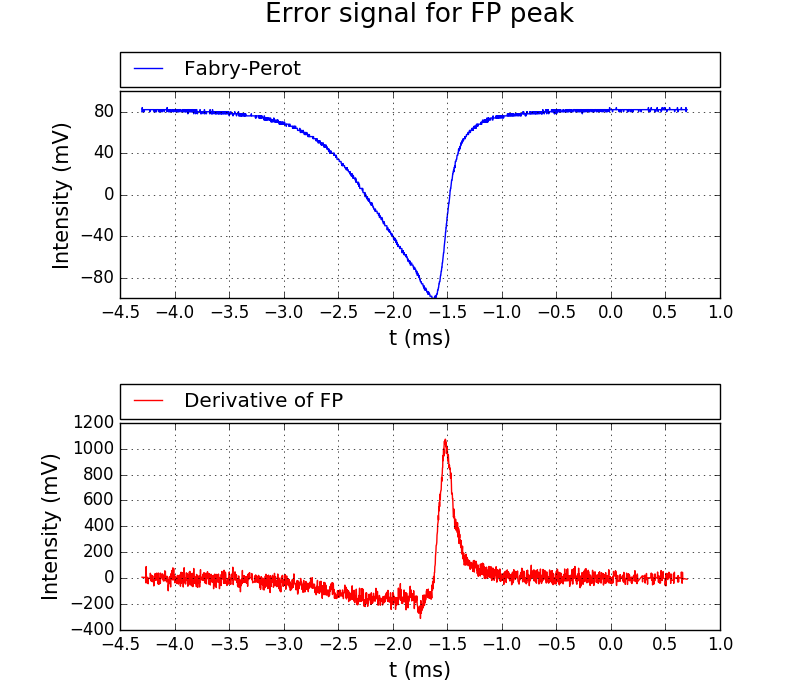

In [4]:
## Plot setup 1

f = plt.figure()
plt.subplots_adjust(top = 0.87, hspace=0.6, left  = 0.15)

#labelDC = {'DC1': "DC 1", 'DC2': "DC 2"}

data_cav = cav*1E3 # Getting backup and changing to mV and ms

## Plot A
ax1 = plt.subplot(211)
plt.plot(data_cav.t, data_cav.DC1)

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['Fabry-Perot'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax1.set_title('Error signal for FP peak', y=1.3, size=19)
ax1.set_xlabel('t (ms)', size=15)
ax1.set_ylabel('Intensity (mV)', size=15)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(40))
ax1.grid(True)

## Plot B
ax2 = plt.subplot(212, sharex=ax1)

df_t = data_cav.copy() # Working with copies of the original

# Applying Savitzky-Golay filter 
dy1 = savgol_filter(df_t.DC1, 35, 2)
df_t.DC1 = dy1

df1 = df_t.diff() # dy on every column
 
# Time derivative
df_t.DC1 = df1.DC1/df1.t

plt.plot(df_t.t, df_t.DC1, color = 'r')

#Lines and legends of ax2
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, ['Derivative of FP'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=3, mode="expand", borderaxespad=0.)

ax2.set_xlabel('t (ms)', size=15)
ax2.set_ylabel('Intensity (mV)', size=15)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2.grid(True)
plt.savefig('cav_peak_dt.svg', bbox_inches='tight', dpi=300)

In [5]:
# S-o-F derivative
left_df_t = df_t[(df_t.t >= -2.41) & (df_t.t <= -2.12)]
right_df_t = df_t[(df_t.t >= -1.50) & (df_t.t <= -1.44)]
print ('Left side-of-fringe derivative = {:.3e} V/s ({:.1f} mV/ms)'
       .format(left_df_t.mean().DC1, left_df_t.mean().DC1) )
print ('Right side-of-fringe derivative = {:.3e} V/s ({:.1f} mV/ms)'
       .format(right_df_t.mean().DC1, right_df_t.mean().DC1) )

Left side-of-fringe derivative = -1.521e+02 V/s (-152.1 mV/ms)
Right side-of-fringe derivative = 7.621e+02 V/s (762.1 mV/ms)


<IPython.core.display.Javascript object>


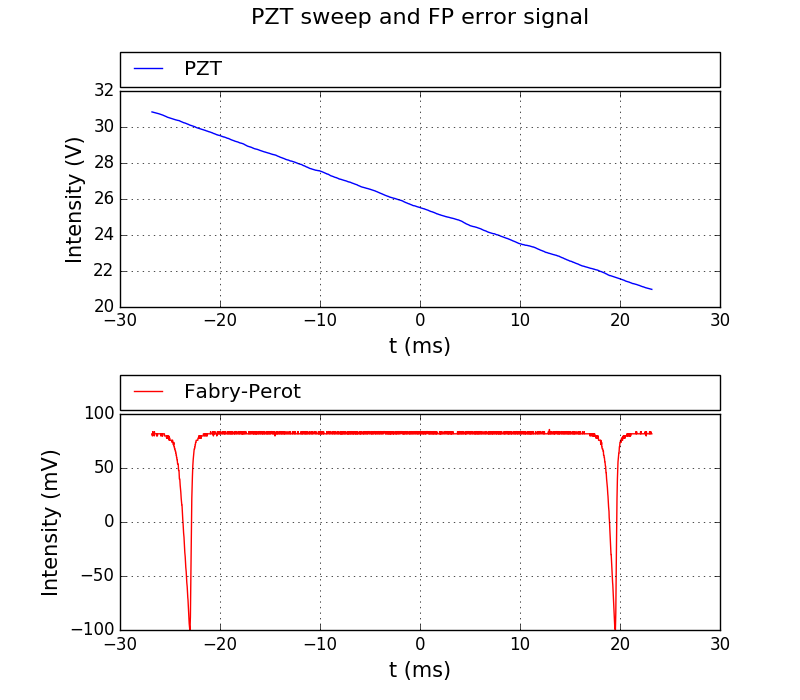

In [6]:
## Plot setup 2

f = plt.figure()
plt.subplots_adjust(top = 0.87, hspace=0.5, left=0.15)

#labelDC = {'DC1': "DC 1", 'DC2': "DC 2"}

# Important for plots and calculations
data_cav2 = cav2*1E3 # Getting backup and changing to mV and ms
data_cav2.DC2 = data_cav2.DC2*10 # Correcting PZT values (monitor controller)

## Plot A
ax1 = plt.subplot(211)

# Applying Savitzky-Golay filter 
dy2 = savgol_filter(data_cav2.DC2, 55, 1)
data_cav2.DC2 = dy2

plt.plot(data_cav2.t, data_cav2.DC2/1E3)

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['PZT'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax1.set_title('PZT sweep and FP error signal', y=1.28, size=16)
ax1.set_xlabel('t (ms)', size=15)
ax1.set_ylabel('Intensity (V)', size=15)
ax1.grid(True)

## Plot B
ax2 = plt.subplot(212, sharex=ax1)

# Applying Savitzky-Golay filter 
#y3_= savgol_filter(data_cav2.DC3, 55, 1)
#data_cav2.DC2 = y3_

plt.plot(data_cav2.t, data_cav2.DC3, color = 'r')

#Lines and legends of ax2
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, ['Fabry-Perot'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=3, mode="expand", borderaxespad=0.)

ax2.set_xlabel('t (ms)', size=15)
ax2.set_ylabel('Intensity (mV)', size=15)
ax2.grid(True)
plt.savefig('PZT_calib.svg', bbox_inches='tight', dpi=300)

In [7]:
## Frequency - time relation

data_cav2 = cav2*1E3 # Getting backup and changing to mV and ms
data_cav2.DC2 = data_cav2.DC2*10 # Correcting PZT values

# Smoothing dataset
y2_= savgol_filter(data_cav2.DC2, 55, 1)
data_cav2.DC2 = y2_

# Check intervals from graph!
left_peak = data_cav2[(data_cav2.t >= -30) & (data_cav2.t <= -20)].copy()
right_peak = data_cav2[(data_cav2.t >= 10) & (data_cav2.t <= 20)].copy()

# Minima indexes 
a = left_peak.DC3.idxmin()
b = right_peak.DC3.idxmin()
dist_t = (abs(right_peak.t[b] - left_peak.t[a]))/1E3 # s

fsr = 1.5E+9 # 1.5 GHz (Thorlabs)
print ('Distance between peaks = {:.1f} ms (FSR = 1.5 GHz)'.format(dist_t*1E3))

# From FSR, we obtain freq/time relation
freq_time = fsr / dist_t # Hz/s

# S-o-F derivative
left_dft_fv = freq_time / left_df_t.mean().DC1  # Hz/V
right_dft_fv = freq_time / right_df_t.mean().DC1 # Hz/V

print ('Relation frequency-time = {:.2e} Hz/s ({:.1f} GHz/s)\n'
       .format(freq_time, freq_time/1E9)) # GHz/s
print('FP derivatives:')
print ('Left side-of-fringe derivative = {:.3e} Hz/V ({:.1f} KHz/mV)'
       .format(left_dft_fv, left_dft_fv/1E6) )
print ('Right side-of-fringe derivative = {:.3e} Hz/V ({:.1f} KHz/mV)\n'
       .format(right_dft_fv, right_dft_fv/1E6) )

## PZT: Voltage - frequency relation

# Voltage difference between peaks
dV = abs(data_cav2.DC2[b] - data_cav2.DC2[a]) # mV
dpzt_t = (dV/1E3) / dist_t  # V/s

freq_volt = freq_time / dpzt_t # Hz/V

print('PZT:')
print ('Relation frequency-voltage = {:.2e} Hz/V ({:.1f} KHz/mV)'
       .format( freq_volt, freq_volt/1E6 )) # KHz/mV


Distance between peaks = 42.5 ms (FSR = 1.5 GHz)
Relation frequency-time = 3.53e+10 Hz/s (35.3 GHz/s)

FP derivatives:
Left side-of-fringe derivative = -2.318e+08 Hz/V (-231.8 KHz/mV)
Right side-of-fringe derivative = 4.627e+07 Hz/V (46.3 KHz/mV)

PZT:
Relation frequency-voltage = 1.77e+08 Hz/V (177.1 KHz/mV)


<IPython.core.display.Javascript object>


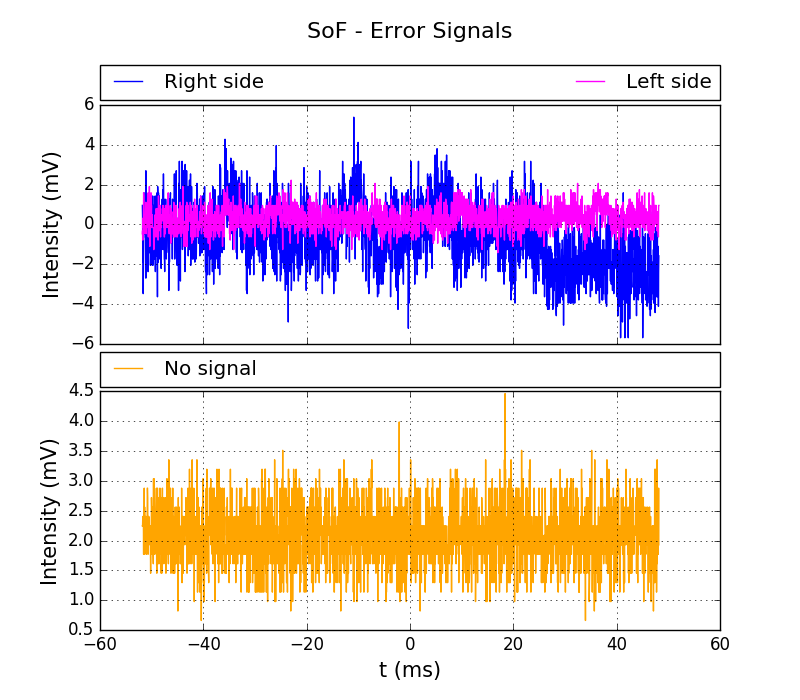

In [19]:
## Plot setup 3

f = plt.figure()

# PID Monitor scale factor
pid_scale = 12.2/6.16 # >> 1.98

# Important for plots and calculations
# Getting backup, changing to mV and ms, and fixing scale
data_lock = lock*1E3
data_lockV = data_lock.copy() # For manipulations in voltage
data_lockV.DC4 = data_lockV.DC4 * pid_scale
data_lockV.DC5 = data_lockV.DC5 * pid_scale
data_lockV.DC6 = data_lockV.DC6 * pid_scale

## Plot A
ax1 = plt.subplot(211)

plt.plot(data_lockV.t, data_lockV.DC4, color='blue')
plt.plot(data_lockV.t, data_lockV.DC5, color='magenta')

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['Right side', 'Left side'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=3, mode="expand", borderaxespad=0.)

ax1.set_title('SoF - Error Signals', y=1.25, size=16)
ax1.set_ylabel('Intensity (mV)', size=15)
ax1.grid(True)

## Plot B
ax2 = plt.subplot(212, sharex=ax1)

plt.plot(data_lockV.t, data_lockV.DC6, color = 'orange')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(top = 0.85, hspace=0.2)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

#Lines and legends of ax2
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, ['No signal'], bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=3, mode="expand", borderaxespad=0.)

ax2.set_xlabel('t (ms)', size=15)
ax2.set_ylabel('Intensity (mV)', size=15)
ax2.grid(True)


In [24]:
## Calculating fluctuations

data_lock = lock # V

# Fluctuations in V (standard deviation)
fluctV_lock1 = data_lock.copy().DC4.std() * pid_scale # V
fluctV_lock2 = data_lock.copy().DC5.std() * pid_scale
fluctV_ns = data_lock.copy().DC6.std() * pid_scale

print ('Fluctuations on Lock 1 = {:.2f} mV'
       .format(fluctV_lock1*1E3) ) 
print ('Fluctuations on Lock 2 = {:.2f} mV'
       .format(fluctV_lock2*1E3) )
print ('Fluctuations without signal = {:.2f} mV\n'
       .format(fluctV_ns*1E3) ) 

fluc_lock1 = fluctV_lock1 * freq_volt
fluc_lock2 = fluctV_lock2 * freq_volt
fluc_ns = fluctV_ns * freq_volt

# Report
print('S-o-F locking fluctuations:')
print ('Fluctuations on Lock 1 = {:.2e} Hz ({:.1f} KHz)'
       .format(fluc_lock1, fluc_lock1/1E3) ) # KHz,
print ('Fluctuations on Lock 2 = {:.2e} Hz ({:.1f} KHz)'
       .format(fluc_lock2, fluc_lock2/1E3) ) # KHz
print ('Fluctuations without signal = {:.2e} Hz ({:.1f} KHz)'
       .format(fluc_ns, fluc_ns/1E3) ) # KHz

Fluctuations on Lock 1 = 1.60 mV
Fluctuations on Lock 2 = 0.58 mV
Fluctuations without signal = 0.48 mV

S-o-F locking fluctuations:
Fluctuations on Lock 1 = 2.83e+05 Hz (283.0 KHz)
Fluctuations on Lock 2 = 1.03e+05 Hz (102.7 KHz)
Fluctuations without signal = 8.51e+04 Hz (85.1 KHz)


<IPython.core.display.Javascript object>


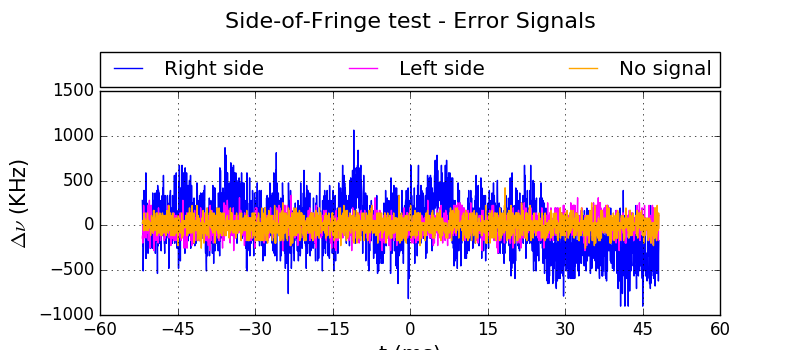

In [26]:
## Plot setup 4

f = plt.figure()
f.subplots_adjust(top = 0.74, hspace=0.2)

fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 9 and height to 6
fig_size[0] = 8
fig_size[1] = 3.5
plt.rcParams["figure.figsize"] = fig_size

# Important for plots and calculations
data_lock = lock # Getting backup in V and s

fluc = data_lock.copy() # for working in frequencies
[fluc.t, fluc.DC4, fluc.DC5, fluc.DC6] = [fluc.t*1E3, # to ms and Hz
                                          fluc.DC4*freq_volt * pid_scale, 
                                          fluc.DC5*freq_volt * pid_scale, 
                                          fluc.DC6*freq_volt * pid_scale]

# Rescaling the y axis as a function of dfreq
[zeroDC4, zeroDC5, zeroDC6] = [fluc.DC4.mean(), # Hz
                               fluc.DC5.mean(), 
                               fluc.DC6.mean()] 

fluc.DC4 = (fluc.DC4 - zeroDC4)/1E3 # KHz
fluc.DC5 = (fluc.DC5 - zeroDC5)/1E3
fluc.DC6 = (fluc.DC6 - zeroDC6)/1E3

## Plot A
ax1 = plt.subplot(111)

plt.plot(fluc.t, fluc.DC4, color='blue')
plt.plot(fluc.t, fluc.DC5, color='magenta')
plt.plot(fluc.t, fluc.DC6, color='orange')

#Lines and legends of ax1
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, ['Right side', 'Left side', 'No signal'], 
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, 
           mode="expand", borderaxespad=0.)

ax1.set_title('Side-of-Fringe test - Error Signals', y=1.25, size=16)
ax1.set_ylabel(r'$\Delta \nu$ (KHz)', size=15)
ax1.set_xlabel('t (ms)', size=15)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax1.grid(True)
plt.savefig('sof_analysis.svg', bbox_inches='tight', dpi=300)